# **Entrega Parcial Procesamiento en la Nube **"
[Jorge Lizarazo](https://www.researchgate.net/profile/Jorge-Lizarazo-Borrero) &
[Leandro León Arce](https://www.linkedin.com/in/leandro-le%C3%B3n-arce-28b98a9/)

<div style="text-align: right"> 
**15/03/2024**
Proyecto creado como nota parcial en la materia de Procesamiento en la Nube de la Universidad Icesi
Evaluada por el Porfesor [Daniel Amariles](https://www.linkedin.com/in/danipilze/)
 </div>

## Introduction
<div style="text-align: right"> 
Utilizando los datos recopilados a través de redes de niebla entre los años 2015 y 2019 en el 
Cerro Montezuma, área adyacente al Parque Nacional Natural Tatamá, llevamos a cabo un proceso de 
extracción de información. Este proceso implicó el análisis de varios conjuntos de datos raster,
incluyendo aquellos de WorldClim 30seg y Hansen GFC (2022 - treecover200), junto con su 
recorte mediante un archivo shapefile de tipo polígono con un buffer alrededor del área de 
reserva (disponible en el enlace de GitHub proporcionado). Posteriormente, fusionamos dos bases
de datos: una con información de campo y otra con datos extraídos de los raster. Realizamos una 
limpieza exhaustiva de los datos para homogeneizar nombres de especies, eliminar información
superflua y estandarizar formatos. Utilizando análisis de componentes principales (PCA), 
determinamos el número mínimo de componentes necesario para representar el 90% de los datos. 
Luego, mediante el algoritmo de agrupamiento K-means, identificamos qué especies se agrupaban 
en qué comunidades, dividiendo así el conjunto en tres comunidades distintas. Finalmente, 
entrenamos un modelo de XGBoost para predecir a qué comunidad pertenecerían las especies a 
partir de los datos extraídos de los raster. Trasladamos este modelo a un escenario geográfico
y generamos distribuciones o regiones ideales para cada comunidad de aves en el área del 
PNN Tatamá y su zona circundante.
 
   
</div>




In [1]:
import findspark
findspark.init()
findspark.find()


'C:\\Users\\ASUS\\anaconda3\\envs\\pyspark-en\\Lib\\site-packages\\pyspark'

In [2]:
## Solo para ver la cosa general con pandas 
import pandas as pd
#df = pd.read_csv('Data_ColombiaGradientes_JFCO.csv', sep=',')
#df.head(2)

,Entrada,Station,Date,Year,month,Day,ID,Station,net,N:,...,Photos,Blood,Parasite,F-Chamber M.,Feather,Notes_Bird,Num_Colect,replica,Anillador,Notes_General
0,621,Tatama,25-Feb-14,2014,Feb,25,1,TA01,NaN,NaN,...,no,NaN,NaN,NaN,Y,"Muestras de plumas R4 y 2P, Marca R5",NaN,NaN,NaN,NaN
1,622,Tatama,25-Feb-14,2014,Feb,25,2,TA01,NaN,NaN,...,no,NaN,NaN,NaN,Y,Muestras 2pecho y 7 rectrices; primarias 1 y 2...,NaN,NaN,NaN,NaN


In [3]:
## Solo general para pillar si son los documentos necesarios
#dj = pd.read_csv('final_df_raster_data.csv', sep=',')
#dj.head(2)

,Estacion,Latitud,Longitud,clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W,clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W,resampled_clipped_wc2.1_30s_bio_1,resampled_clipped_wc2.1_30s_bio_10,resampled_clipped_wc2.1_30s_bio_11,resampled_clipped_wc2.1_30s_bio_12,resampled_clipped_wc2.1_30s_bio_13,...,resampled_clipped_wc2.1_30s_bio_19,resampled_clipped_wc2.1_30s_bio_2,resampled_clipped_wc2.1_30s_bio_3,resampled_clipped_wc2.1_30s_bio_4,resampled_clipped_wc2.1_30s_bio_5,resampled_clipped_wc2.1_30s_bio_6,resampled_clipped_wc2.1_30s_bio_7,resampled_clipped_wc2.1_30s_bio_8,resampled_clipped_wc2.1_30s_bio_9,resampled_clipped_wc2.1_30s_elev
0,TA01,5.223194,-76.080167,0,45,19.033333,19.383333,18.8,2965.0,416.0,...,970.0,7.816667,90.89148,23.580935,23.3,14.7,8.599999,18.8,18.983334,1493
1,TA2,5.223056,-76.078000,0,95,19.033333,19.383333,18.8,2965.0,416.0,...,970.0,7.816667,90.89148,23.580935,23.3,14.7,8.599999,18.8,18.983334,1493


In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, coalesce, concat
from pyspark.sql.functions import when, count, col, regexp_replace, lit

In [5]:
spark = SparkSession\
    .builder \
    .appName("Proyecto_Gradientes_Tatama") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [229]:
import requests
# URL del archivo CSV en GitHub
csv_url = 'https://raw.githubusercontent.com/jorgelizarazo94/Cloud_procesing/6487afb8aa687ce23512c4962e79a432f08cc32d/Data/final_df_raster_data.csv'

# Utiliza requests para descargar el archivo CSV
r = requests.get(csv_url)
with open('final_df_raster_data.csv', 'wb') as f:
    f.write(r.content)

    
    
csv_url2 = 'https://github.com/jorgelizarazo94/Cloud_procesing/blob/6487afb8aa687ce23512c4962e79a432f08cc32d/Data/Data_ColombiaGradientes_JFCO.csv'

# Utiliza requests para descargar el archivo CSV
r = requests.get(csv_url2)
with open('Data_ColombiaGradientes_JFCO.csv', 'wb') as f:
    f.write(r.content)    
    

In [230]:
dj_spark = spark.read.option('header', 'true').csv('final_df_raster_data.csv', 
                                                   header=True, inferSchema=True)
dj_spark = dj_spark.withColumnRenamed("Estacion", "Station")
#dj_spark = dj_spark.withColumnRenamed("Elevacion", "Elevation")

dj_spark.show(20)

+-------+------------------+------------------+-----------------------------------------------+----------------------------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+--------------------------------+
|Station|           Latitud|          Longitud|clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W|clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W|resampled_clip

In [7]:
# Split the 'Station' column based on '_'
split_col = split(dj_spark['Station'], '_')
dj_spark = dj_spark.withColumn('Station_new', split_col.getItem(0)) \
                   .withColumn('Station_sample',
                               when(split_col.getItem(1).isNull(), 
                                    lit('first'))
                               .otherwise(concat(lit('S'), split_col.getItem(1))))

# Show the result
dj_spark.show(20)

+-------+------------------+------------------+-----------------------------------------------+----------------------------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+--------------------------------+-----------+--------------+
|Station|           Latitud|          Longitud|clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W|clipped_Hansen_GFC-2022-v1.10_treecover2

In [8]:
dj_spark = dj_spark.drop('Station').withColumnRenamed('Station_new', 'Station')

dj_spark.show(20, False)

+------------------+------------------+-----------------------------------------------+----------------------------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+--------------------------------+-------+--------------+
|Latitud           |Longitud          |clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W|clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W|resampl

In [9]:
df_spark = spark.read.option('header', 'true').csv('Data_ColombiaGradientes_JFCO.csv', 
                                                   header=True, inferSchema=True)

In [10]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [11]:
df_spark.show(5)

+-------+--------+---------+----+-----+---+---+-------+----+----+----+---------+--------+----+---------+------------+-------------+------------+-----------+--------------------+-------------+--------------------+-----+---------+-----+------------+--------------+-------------+-------------+------------+------+-----+------------+--------------+---------------+------------------+---------+---+--------------+------+---+-----------+-----------+---+---------+---------------+---------+-----------+-------------+---------+---------+------------+------------+------------+------------+-----+-------+--------+------+------------+------+-----+--------+------------+-------+--------------------+----------+-------+---------+-------------+
|Entrada|Station |     Date|Year|month|Day| ID|Station| net|  N:|  W:|Elev. (m)|altitude|time|Band_Code|Color_Anillo|        Order|      Family|      Genus|             Species|code _Species|         common_name|Recap|new_recap| Mass|Culmen_Total|Culmen_Exposed|PW bil

In [12]:
df_spark = df_spark.drop("N:", "W:")

df_spar = df_spark.join(dj_spark, ["Station"], "left")
#df_spar.printSchema()
df_spa = df_spar.drop("Localidad", "Elev. (m)", "net", "Notes_General",
                      "Anillador", "replica", "Num_Colect", "Notes_Bird", "Blood", "Photos",
                      "Feather", "F-Chamber M.", "Parasite", "Iris_Color", "Status", "How_aged",
                      "How_sex", "Skull", "Code_cycle", "Cycle_WRP", "Molt_ Limit", "molt_notes",
                      "Wear_tail", "Molt_tail", "Fheather_wear", "FLIGHT_MOLT", "Body_Molt",
                       "Pectoral_Muscle", "Condition", "Fat", "Station ", "P-S", "Sex", "age_Historical",
                     "Rep", "Pro_Cloacal", "Brood_Patch", "Pro_Cloacal", "External_Rectrices",
                     "new_recap", "common_name", "Color_Anillo","time","altitude", "Recap","Band_Code")
df_spa.show(20)

+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+----+------------+--------------+-------------+-------------+------------+------+-----+------------+--------------+---------------+---------+-----------------+------------------+-----------------------------------------------+----------------------------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------

In [13]:
df_spa = df_spa \
    .withColumnRenamed("clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W",
                       "lossyear") \
    .withColumnRenamed("clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W", 
                       "treecover") \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_1", "bio_1") \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_2", "bio_2")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_3", "bio_3")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_4", "bio_4")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_5", "bio_5")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_6", "bio_6")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_7", "bio_7")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_8", "bio_8")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_9", "bio_9")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_10", "bio_10") \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_11", "bio_11")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_12", "bio_12")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_13", "bio_13")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_14", "bio_14")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_15", "bio_15")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_16", "bio_16")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_17", "bio_17")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_18", "bio_18")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_bio_19", "bio_19")  \
    .withColumnRenamed("resampled_clipped_wc2.1_30s_elev", "elev")  

# Mostrar el esquema del DataFrame modificado para verificar los cambios
df_spa.printSchema()

root
 |-- Station: string (nullable = true)
 |-- Entrada: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- Day: integer (nullable = true)
 |-- ID: string (nullable = true)
 |-- Order: string (nullable = true)
 |-- Family: string (nullable = true)
 |-- Genus: string (nullable = true)
 |-- Species: string (nullable = true)
 |-- code _Species: string (nullable = true)
 |-- Mass: string (nullable = true)
 |-- Culmen_Total: string (nullable = true)
 |-- Culmen_Exposed: string (nullable = true)
 |-- PW bill_width: string (nullable = true)
 |-- PH bill_depth: string (nullable = true)
 |-- Culmen_gapes: string (nullable = true)
 |-- Tarsus: string (nullable = true)
 |-- Halux: string (nullable = true)
 |-- Nail_1finger: string (nullable = true)
 |-- feet_extension: string (nullable = true)
 |-- Central_rectrix: string (nullable = true)
 |-- Wing_cord: string (nullable = true)
 |-- Latitud: double (nulla

In [14]:
df_spa.show(2)

+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+----+------------+--------------+-------------+-------------+------------+------+-----+------------+--------------+---------------+---------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+------+--------+--------+---------+-----+-----+--------+-----+---------+----+--------------+
|Station|Entrada|     Date|Year|month|Day| ID|      Order|     Family|      Genus|             Species|code _Species|Mass|Culmen_Total|Culmen_Exposed|PW bill_width|PH bill_depth|Culmen_gapes|Tarsus|Halux|Nail_1finger|feet_extension|Central_rectrix|Wing_cord|          Latitud|          Longitud|lossyear|treecover|    bio_1|   bio_10|bio_11|bio_12|bio_13|bio_14|  bio_15|bio_16|bio_17|bio_18|bio_19|   bio_2|   bio_3|    bio_4|bio_5|bio_6|   bio_7|bio_8|    bio_9|elev|Station_sample|
+-------+-------+---------+---

In [15]:
from pyspark.sql.types import StringType
for column in df_spa.columns:
    if isinstance(df_spa.schema[column].dataType, StringType):
        df_spa = df_spa.withColumn(column, when(col(column) == "NA", None).otherwise(col(column)))

In [16]:
# Contar los valores NA en la columna Latitud
na_count = df_spa.agg(
    count(when(col("elev").isNull(), True))
).collect()[0][0]

print("valores NA en --:", na_count)

valores NA en --: 0


In [17]:
na_counts = df_spa.select([count(when(col(c).isNull(),
                                      c)).alias(c) for c in df_spa.columns]).collect()[0].asDict()

# Imprime el conteo de valores NA por columna
for column, na_count in na_counts.items():
    print(f"Número de valores NA en la columna {column}: {na_count}")

Número de valores NA en la columna Station: 0
Número de valores NA en la columna Entrada: 0
Número de valores NA en la columna Date: 0
Número de valores NA en la columna Year: 0
Número de valores NA en la columna month: 0
Número de valores NA en la columna Day: 0
Número de valores NA en la columna ID: 0
Número de valores NA en la columna Order: 21
Número de valores NA en la columna Family: 84
Número de valores NA en la columna Genus: 63
Número de valores NA en la columna Species: 0
Número de valores NA en la columna code _Species: 2793
Número de valores NA en la columna Mass: 10164
Número de valores NA en la columna Culmen_Total: 10038
Número de valores NA en la columna Culmen_Exposed: 36267
Número de valores NA en la columna PW bill_width: 10710
Número de valores NA en la columna PH bill_depth: 35889
Número de valores NA en la columna Culmen_gapes: 49476
Número de valores NA en la columna Tarsus: 21987
Número de valores NA en la columna Halux: 49539
Número de valores NA en la columna 

In [18]:
#### Posiblemente algunas especies esten mal escritas o duplicadas por error en typing then...
#unique_species = df_spa.select("Species").distinct().collect()
#print(unique_species)

In [19]:
#unique_species = [row['Species'] for row in unique_species]

In [20]:
#import csv
#with open('unique_speciesk.csv', 'w', newline='', encoding='utf-8') as file:
#    writer = csv.writer(file)
#    writer.writerow(['Species'])  # escribir el encabezado
#    for species in unique_species:
#        writer.writerow([species])

In [18]:
#########################################################################################
specie_colum = spark.read.option('header', 'true').csv('updated_species.csv', 
                                                   header=True, inferSchema=True)

In [19]:

df_spa_updated = df_spa.join(specie_colum, df_spa["Species"] == specie_colum["Species1"], "left")
df_spa_updated = df_spa_updated.withColumn("Species", coalesce(col("Species_new"), col("Species")))
df_sp = df_spa_updated.drop("Species_new", "Species1")
df_sp = df_sp.filter(~(col("Species").isin(["Buscar", "buscar"])))

In [20]:
df_sp.show(2)

+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+----+------------+--------------+-------------+-------------+------------+------+-----+------------+--------------+---------------+---------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+------+--------+--------+---------+-----+-----+--------+-----+---------+----+--------------+
|Station|Entrada|     Date|Year|month|Day| ID|      Order|     Family|      Genus|             Species|code _Species|Mass|Culmen_Total|Culmen_Exposed|PW bill_width|PH bill_depth|Culmen_gapes|Tarsus|Halux|Nail_1finger|feet_extension|Central_rectrix|Wing_cord|          Latitud|          Longitud|lossyear|treecover|    bio_1|   bio_10|bio_11|bio_12|bio_13|bio_14|  bio_15|bio_16|bio_17|bio_18|bio_19|   bio_2|   bio_3|    bio_4|bio_5|bio_6|   bio_7|bio_8|    bio_9|elev|Station_sample|
+-------+-------+---------+---

In [21]:
## Sera mejor eliminar los espacios y solo usar _ para genero y epiteto especifico
df_sp = df_sp.withColumn("Species", regexp_replace(col("Species"), " ", "_"))
#df_sp.show(3)

In [22]:
#### Solo para rectificar que los cambios estan bien y ya nos vamos con estas especies...
unique_species = df_sp.select("Species").distinct().collect()
print(unique_species)

[Row(Species='Phylloscartes_ophthalmicus'), Row(Species='Habia_cristata'), Row(Species='Picumnus_cinnamomeus'), Row(Species='Myrmotherulia_schisticolor'), Row(Species='Haplophaedia_aureliae'), Row(Species='Tangara_labradorides'), Row(Species='Creurgops_verticalis'), Row(Species='Troglodytes_aedon'), Row(Species='Myadestes_ralloides'), Row(Species='Thripadectes_holostictus'), Row(Species='Aulacorhynchus_prasinus'), Row(Species='Catharus_minimus'), Row(Species='Clibanornis_rubiginosus'), Row(Species='Xenops_MInutus'), Row(Species='Myrmotherula_schiticolor'), Row(Species='Veniliornis_dignus'), Row(Species='Aglaiocercus_coelestis'), Row(Species='Oreothraupis_arremonops'), Row(Species='Thripadectes_ignobilis'), Row(Species='Chlorospingus_semifuscus'), Row(Species='Psarocolius_wagleri'), Row(Species='Myiothlypis_fulvicauda'), Row(Species='Xiphorhynchus_triangularis'), Row(Species='Arremon_castaneiceps'), Row(Species='Platyrinchus_coronatus'), Row(Species='Catamblyrhynchus_diadema'), Row(Spec

In [23]:
df_sp.show(2)

+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+----+------------+--------------+-------------+-------------+------------+------+-----+------------+--------------+---------------+---------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+------+--------+--------+---------+-----+-----+--------+-----+---------+----+--------------+
|Station|Entrada|     Date|Year|month|Day| ID|      Order|     Family|      Genus|             Species|code _Species|Mass|Culmen_Total|Culmen_Exposed|PW bill_width|PH bill_depth|Culmen_gapes|Tarsus|Halux|Nail_1finger|feet_extension|Central_rectrix|Wing_cord|          Latitud|          Longitud|lossyear|treecover|    bio_1|   bio_10|bio_11|bio_12|bio_13|bio_14|  bio_15|bio_16|bio_17|bio_18|bio_19|   bio_2|   bio_3|    bio_4|bio_5|bio_6|   bio_7|bio_8|    bio_9|elev|Station_sample|
+-------+-------+---------+---

In [24]:
df_sp = df_sp.drop("Wing_cord", "code _Species", 'Central_rectrix', "PW bill_width",
                     'feet_extension', 'Nail_1finger', 'Halux', 'Tarsus', 'Culmen_gapes' , 
                      'PH bill_depth','Culmen_Exposed',  'Culmen_Total', 'Mass')

In [25]:
from pyspark.sql.functions import monotonically_increasing_id
df_sp = df_sp.withColumn("id", monotonically_increasing_id())

df_sp.show(2)

+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+------+--------+--------+---------+-----+-----+--------+-----+---------+----+--------------+
|Station|Entrada|     Date|Year|month|Day| id|      Order|     Family|      Genus|             Species|PW bill_width|          Latitud|          Longitud|lossyear|treecover|    bio_1|   bio_10|bio_11|bio_12|bio_13|bio_14|  bio_15|bio_16|bio_17|bio_18|bio_19|   bio_2|   bio_3|    bio_4|bio_5|bio_6|   bio_7|bio_8|    bio_9|elev|Station_sample|
+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+------+--------+--------+---------+-----+-----+--------+-----

In [26]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
import numpy as np
import matplotlib.pyplot as plt

In [27]:
columns_for_pca = ["treecover", "bio_1", "bio_10", "bio_11", "bio_12", "bio_13", "bio_14", "bio_15", 
                   "bio_16", "bio_17", "bio_18", "bio_19", "bio_2", "bio_3", "bio_4", "bio_5", "bio_6", "bio_7", 
                   "bio_8", "bio_9", "elev"]

In [28]:
assembler = VectorAssembler(inputCols=columns_for_pca, outputCol="features")
df_vector = assembler.transform(df_sp)

In [29]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df_vector)
df_scaled = scalerModel.transform(df_vector)
df_scaled.show(6)

+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+------+--------+--------+---------+-----+-----+--------+-----+---------+----+--------------+--------------------+--------------------+
|Station|Entrada|     Date|Year|month|Day| id|      Order|     Family|      Genus|             Species|PW bill_width|          Latitud|          Longitud|lossyear|treecover|    bio_1|   bio_10|bio_11|bio_12|bio_13|bio_14|  bio_15|bio_16|bio_17|bio_18|bio_19|   bio_2|   bio_3|    bio_4|bio_5|bio_6|   bio_7|bio_8|    bio_9|elev|Station_sample|            features|      scaledFeatures|
+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+-------

In [30]:
n_components = len(columns_for_pca)

In [31]:
pca = PCA(k=n_components, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(df_scaled)
df_pca = pcaModel.transform(df_scaled)

In [32]:
# Varianza explicada por cada componente principal
explainedVariance = pcaModel.explainedVariance
# Varianza acumulada
cumulativeVariance = explainedVariance.cumsum()

In [33]:
print("Varianza explicada por cada componente principal:")
print(explainedVariance)

Varianza explicada por cada componente principal:
[0.7432952779327794,0.12998221241187907,0.04817708788095776,0.04164101832457,0.018502906414520206,0.011051574919055781,0.0031070658744734177,0.001637100231766085,0.0010650491820818266,0.0007299359706796621,0.0004374224961990203,0.00025347735953235457,7.251391294561552e-05,3.474961683847048e-05,1.0703268831694875e-05,1.7847320080810641e-06,9.278156778362384e-08,2.4064112238068714e-08,2.625124902246856e-09,4.978739172667878e-14,2.6864249417919408e-14]


In [34]:
print("\nVarianza acumulada:")
print(cumulativeVariance)


Varianza acumulada:
[0.74329528 0.87327749 0.92145458 0.9630956  0.9815985  0.99265008
 0.99575714 0.99739424 0.99845929 0.99918923 0.99962665 0.99988013
 0.99995264 0.99998739 0.9999981  0.99999988 0.99999997 1.
 1.         1.         1.        ]


In [36]:
optimal_k = np.argmax(cumulativeVariance >= 0.90) + 1  # +1 porque los índices en Python empiezan en 0
print("\nC90% de varianza explicada:", optimal_k)


C90% de varianza explicada: 3


In [47]:
######################################################################################333
df_pca.show(2)

+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+------+--------+--------+---------+-----+-----+--------+-----+---------+----+--------------+--------------------+--------------------+--------------------+
|Station|Entrada|     Date|Year|month|Day| id|      Order|     Family|      Genus|             Species|PW bill_width|          Latitud|          Longitud|lossyear|treecover|    bio_1|   bio_10|bio_11|bio_12|bio_13|bio_14|  bio_15|bio_16|bio_17|bio_18|bio_19|   bio_2|   bio_3|    bio_4|bio_5|bio_6|   bio_7|bio_8|    bio_9|elev|Station_sample|            features|      scaledFeatures|         pcaFeatures|
+-------+-------+---------+----+-----+---+---+-----------+-----------+-----------+--------------------+-------------+-----------------+------------------+--------+---------+---------+---

In [48]:
# Ensamblar solo las columnas que se utilizarán para PCA
assembler = VectorAssembler(inputCols=columns_for_pca, outputCol="features")
df_vector = assembler.transform(df_sp)

In [49]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df_vector)
df_scaled = scalerModel.transform(df_vector)

In [50]:
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(df_scaled)
df_pca = pcaModel.transform(df_scaled)

In [55]:
df_pca.select("pcaFeatures").show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[56.038461529057415,-11.052202954735705,21.779740548918824]|
|[56.038461529057415,-11.052202954735705,21.779740548918824]|
|[56.038461529057415,-11.052202954735705,21.779740548918824]|
|[56.037949245249855,-11.078376771435948,21.522740004571258]|
|[56.037949245249855,-11.078376771435948,21.522740004571258]|
|[56.038461529057415,-11.052202954735705,21.779740548918824]|
|[56.037949245249855,-11.078376771435948,21.522740004571258]|
|[56.02975270432888,-11.497157838639826,17.410731295010205] |
|[56.02872813671375,-11.54950547204031,16.89673020631507]   |
|[56.037949245249855,-11.078376771435948,21.522740004571258]|
|[56.037949245249855,-11.078376771435948,21.522740004571258]|
|[56.02934287728283,-11.51809689200002,17.20513085953215]   |
|[56.03251903688971,-11.355819228458518,18.798534234487057] |
|[56.037

In [52]:

from pyspark.ml.clustering import KMeans

In [60]:
k = 3

# Configura KMeans para que utilice la columna 'pcaFeatures'
kmeans = KMeans().setK(k).setSeed(123).setFeaturesCol("pcaFeatures")

# Ajusta el modelo KMeans utilizando solo las columnas 'id' y 'pcaFeatures'
model = kmeans.fit(df_pca.select('id', 'pcaFeatures'))

# Realiza las predicciones
predictions = model.transform(df_pca.select('id', 'pcaFeatures'))

# Une las predicciones con el DataFrame original para añadir la columna de predicciones
df_sp_with_predictions = df_sp.join(predictions, 'id')


In [64]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Suponiendo que 'model' es el modelo KMeans ya ajustado y 'predictions' contiene las predicciones

# Inercia (coste de entrenamiento)
inertia = model.summary.trainingCost

# Coeficiente de silueta
evaluator = ClusteringEvaluator(featuresCol="pcaFeatures")
silhouette = evaluator.evaluate(predictions)

print("Coeficiente de silueta:", silhouette)

print("Inercia:", inertia)

Coeficiente de silueta: 0.7635437048318442
Inercia: 259979.75872146673


In [66]:
# Muestra las primeras filas con las predicciones añadidas
df_sp_with_predictions.show(4)

+---+-------+-------+---------+----+-----+---+-------------+----------+---------+--------------------+-------------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+------+--------+--------+---------+-----+-----+--------+-----+---------+----+--------------+--------------------+----------+
| id|Station|Entrada|     Date|Year|month|Day|        Order|    Family|    Genus|             Species|PW bill_width|          Latitud|          Longitud|lossyear|treecover|    bio_1|   bio_10|bio_11|bio_12|bio_13|bio_14|  bio_15|bio_16|bio_17|bio_18|bio_19|   bio_2|   bio_3|    bio_4|bio_5|bio_6|   bio_7|bio_8|    bio_9|elev|Station_sample|         pcaFeatures|prediction|
+---+-------+-------+---------+----+-----+---+-------------+----------+---------+--------------------+-------------+-----------------+------------------+--------+---------+---------+---------+------+------+------+------+--------+------+------+------+

In [67]:
df_pandas = df_sp_with_predictions.toPandas()

# Separar características y etiquetas
X = df_pandas[['treecover', 'bio_1', 'bio_10', 'bio_11', 'bio_12', 'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18', 'bio_19', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7', 'bio_8', 'bio_9', 'elev']]
y = df_pandas['prediction']

In [107]:
X.head()

,treecover,bio_1,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,...,bio_19,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,elev
0,95,19.033333,19.383333,18.8,2965.0,416.0,152.0,34.28378,970.0,532.0,...,970.0,7.816667,90.89148,23.580935,23.3,14.7,8.599999,18.8,18.983334,1493
1,0,19.033333,19.383333,18.8,2965.0,416.0,152.0,34.28378,970.0,532.0,...,970.0,7.816667,90.89148,23.580935,23.3,14.7,8.599999,18.8,18.983334,1493
2,37,19.033333,19.383333,18.8,2965.0,416.0,152.0,34.28378,970.0,532.0,...,970.0,7.816667,90.89148,23.580935,23.3,14.7,8.599999,18.8,18.983334,1493
3,95,19.033333,19.383333,18.8,2965.0,416.0,152.0,34.28378,970.0,532.0,...,970.0,7.816667,90.89148,23.580935,23.3,14.7,8.599999,18.8,18.983334,1493
4,95,19.033333,19.383333,18.8,2965.0,416.0,152.0,34.28378,970.0,532.0,...,970.0,7.816667,90.89148,23.580935,23.3,14.7,8.599999,18.8,18.983334,1493


In [91]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir los conjuntos a DMatrix, que es el formato preferido por XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [92]:
from sklearn.metrics import f1_score



In [93]:
def objective(space):
    clf = xgb.train(space, dtrain, num_boost_round=1000, evals=[(dtest, "test")], early_stopping_rounds=30, verbose_eval=False)
    
    preds = clf.predict(dtest)
    # Asegúrate de que 'preds' sean las clases predichas para calcular F1-score
    preds = np.asarray([np.argmax(line) for line in preds])
    f1 = f1_score(y_test, preds, average='weighted')  # 'weighted' considera el desbalance de clases
    
    # Hyperopt minimiza la función objetivo; se retorna 1 - F1 para maximizar el F1-score
    return {'loss': 1 - f1, 'status': STATUS_OK}

space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'eta': hp.uniform('eta', 0.01, 0.3),
    'objective': 'multi:softmax',
    'num_class': 3,
    'lambda': hp.uniform('lambda', 1e-8, 1.0),  # Regularización L2
    'alpha': hp.uniform('alpha', 1e-8, 1.0)  # Regularización L1
}

trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print("Los mejores hiperparámetros son: ", best_hyperparams)

100%|██████████| 100/100 [03:04<00:00,  1.84s/trial, best loss: 0.7035852236355664]
Los mejores hiperparámetros son:  {'alpha': 0.6590523500251971, 'eta': 0.16275265224049576, 'lambda': 0.0033755891434843924, 'max_depth': 12}


In [94]:
import joblib

In [95]:
final_params = {
    'max_depth': 12,
    'eta': 0.16275265224049576,
    'objective': 'multi:softmax',
    'num_class': 3,
    'lambda': 0.0033755891434843924,
    'alpha': 0.6590523500251971
}

In [96]:
final_bst = xgb.train(final_params, dtrain, num_boost_round=1000)

# Guardar el modelo
joblib.dump(final_bst, "xgboost_aves_model.dat")

['xgboost_aves_model.dat']

In [147]:
import rasterio
import os
from rasterio.enums import Resampling

In [ ]:
###########################################3 Mapping

In [108]:
xgb_model = joblib.load("xgboost_aves_model.dat")


In [113]:
def read_rasters_and_stack(raster_files, folder_path):
    data = []
    for file in raster_files:
        with rasterio.open(os.path.join(folder_path, file)) as src:
            band = src.read(1)  # read only the first band
            data.append(band)
    return np.stack(data, axis=-1)  # stack rasters

In [114]:
nombres_columnas = X.columns.tolist()
nombres_columnas

['treecover',
 'bio_1',
 'bio_10',
 'bio_11',
 'bio_12',
 'bio_13',
 'bio_14',
 'bio_15',
 'bio_16',
 'bio_17',
 'bio_18',
 'bio_19',
 'bio_2',
 'bio_3',
 'bio_4',
 'bio_5',
 'bio_6',
 'bio_7',
 'bio_8',
 'bio_9',
 'elev']

In [142]:
folder_path = 'resampled_rasters'


raster_files = ['r_aligned_clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W.tif',
 'resampled_clipped_wc2.1_30s_bio_1.tif',
 'resampled_clipped_wc2.1_30s_bio_10.tif',
 'resampled_clipped_wc2.1_30s_bio_11.tif',
 'resampled_clipped_wc2.1_30s_bio_12.tif',
 'resampled_clipped_wc2.1_30s_bio_13.tif',
 'resampled_clipped_wc2.1_30s_bio_14.tif',
 'resampled_clipped_wc2.1_30s_bio_15.tif',
 'resampled_clipped_wc2.1_30s_bio_16.tif',
 'resampled_clipped_wc2.1_30s_bio_17.tif',
 'resampled_clipped_wc2.1_30s_bio_18.tif',
 'resampled_clipped_wc2.1_30s_bio_19.tif',
 'resampled_clipped_wc2.1_30s_bio_2.tif',
 'resampled_clipped_wc2.1_30s_bio_3.tif',
 'resampled_clipped_wc2.1_30s_bio_4.tif',
 'resampled_clipped_wc2.1_30s_bio_5.tif',
 'resampled_clipped_wc2.1_30s_bio_6.tif',
 'resampled_clipped_wc2.1_30s_bio_7.tif',
 'resampled_clipped_wc2.1_30s_bio_8.tif',
 'resampled_clipped_wc2.1_30s_bio_9.tif',
 'resampled_clipped_wc2.1_30s_elev.tif'
]

In [144]:
# Check shapes of all rasters
for file in raster_files:
    with rasterio.open(os.path.join(folder_path, file)) as src:
        print(file, src.shape)

r_aligned_clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_1.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_10.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_11.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_12.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_13.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_14.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_15.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_16.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_17.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_18.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_19.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_2.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_3.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_4.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_5.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_6.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_7.tif (1634, 1534)
resampled_clipped_wc2.1_30s_bio_8.tif (1634

In [143]:
# Read the rasters
raster_stack = read_rasters_and_stack(raster_files, folder_path)

In [148]:
# Reshape the raster stack for prediction
num_features = raster_stack.shape[-1]
raster_stack_reshaped = raster_stack.reshape(-1, num_features)

In [151]:
feature_names = ['treecover', 'bio_1', 'bio_10', 'bio_11', 'bio_12', 'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18', 'bio_19', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7', 'bio_8', 'bio_9', 'elev']

# Create the DMatrix for prediction, specifying feature names
dtest = xgb.DMatrix(raster_stack_reshaped, feature_names=feature_names)

# Predict using the model
predictions = model.predict(dtest)

In [152]:
predictions_reshaped = predictions.reshape(raster_stack.shape[0], raster_stack.shape[1])


In [153]:
with rasterio.open(os.path.join(folder_path, raster_files[0])) as src:
    meta = src.meta.copy()
    meta.update(dtype='uint8', count=1)  # Assuming predictions are categorical

with rasterio.open('predictions.tif', 'w', **meta) as dst:
    dst.write(predictions_reshaped.astype('uint8'), 1)


In [167]:
######################################################################
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show


In [205]:
shapefile_path = 'Shape/tTatama.shp'  # Ruta al archivo shapefile
raster_path = 'predictions.tif'       # Ruta al archivo raster
# Leer el shapefile usando Geopandas
shapes = gpd.read_file(shapefile_path)

Valores únicos en el raster: [0 1 2]


In [226]:
import geopandas as gpd

import rasterio.mask
import matplotlib.colors

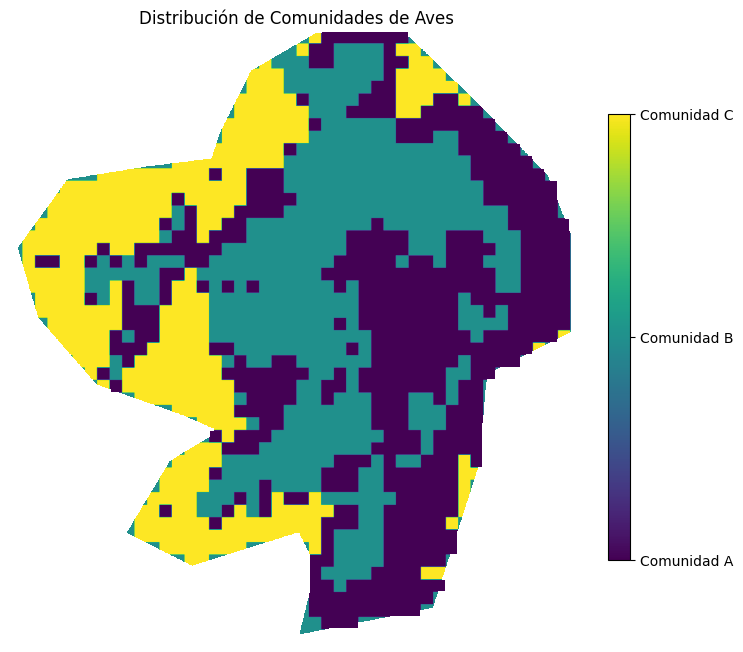

In [225]:
nodata_value = -9999

shapes = gpd.read_file('Shape/tTatama.shp')

# Leer el raster de predicciones usando Rasterio
with rasterio.open('predictions.tif') as src:
    # Leer la primera banda del raster como un MaskedArray
    raster_data = src.read(1, masked=True)
    
    # Crea una máscara para el raster basada en el shapefile, donde todo fuera de la geometría sea True
    raster_mask, out_transform = rasterio.mask.mask(src, shapes.geometry, invert=True)
    # Combina la máscara de la geometría con la máscara existente en los datos
    raster_data.mask |= raster_mask[0]

# Asignar el colormap manualmente
cmap = plt.cm.viridis  # o cualquier otro colormap que prefieras
cmap.set_bad('white')  # Asignar el color blanco para valores nodata/máscara

# Crear la figura y los ejes para el mapa
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(raster_data, cmap=cmap)

# Agregar la barra de colores con etiquetas para las comunidades
colorbar = fig.colorbar(img, ax=ax, fraction=0.036, pad=0.04, ticks=[0, 1, 2])
colorbar.ax.set_yticklabels(['Comunidad A', 'Comunidad B', 'Comunidad C'])

# Esconder los ejes
ax.axis('off')

# Agregar título
ax.set_title('Distribución de Comunidades de Aves')

# Mostrar el gráfico
plt.show()